In [120]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.inspection import permutation_importance
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import catboost
import optuna

import eli5
from eli5.sklearn import PermutationImportance

In [96]:
### y_quality?

In [97]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [98]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission.csv')

In [99]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [100]:
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')
train['LINE'] = train['LINE'].astype('category')

In [101]:
# 열에서 모든 값이 nan이면 train, test에서 열 제거
def remove_col(train_df, test_df):
    for x in train_df.columns[6:]:
        if train_df[x].nunique() == 0 or list(train_df[x].unique()) == [0]:
            train_df.drop(columns=[x], inplace=True)
            test_df.drop(columns=[x], inplace=True)
    return train_df, test_df

In [102]:
train, test = remove_col(train, test)

In [103]:
train.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Quality'], inplace=True)

test = test[train.columns[1:]]

In [104]:
train_x, train_y = train.drop(columns=['Y_Class']), train['Y_Class']

In [105]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN
3,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,NaN
4,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,NaN


In [106]:
# 상관계수 == 1 이면 제거
def same_corr_drop(train_df):
    tmp = train_df[train_df.columns[2:]].corr()
    for e, c in enumerate(tmp.columns):
        for i in range(e+1, len(tmp.columns)):
            if abs(tmp[c][i]) == 1 and tmp.columns[i] in train_df.columns:
                train_df.drop(columns=[tmp.columns[i]], inplace=True)
    return train_df

train_x = same_corr_drop(train_x)
test = test[train_x.columns]

In [107]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2799,X_2800,X_2801,X_2837,X_2839,X_2840,X_2841,X_2842,X_2843,X_2871
0,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,22.925926,20.0,9.04,5.02,7.00,40.06,0.000331,0.000033,NaN
1,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.0,25.050000,24.0,8.00,5.00,7.05,36.54,0.001150,0.000009,NaN
2,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.0,23.962963,22.0,9.04,5.02,6.52,40.05,0.000332,0.000033,NaN
3,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.0,25.037037,23.0,7.49,5.01,7.03,40.03,0.001210,0.000008,NaN
4,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.0,24.000000,22.0,9.04,5.03,6.52,40.07,0.000334,0.000041,NaN


### catboost cv

In [108]:
train_y.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

In [109]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU') # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

15it [05:10, 20.69s/it]

0.5330352707401887 : [0.14285714 0.68067227 0.68067227] ~ 0.7671081919357782 : [0.14285714 0.68067227 0.68067227]
mean : 0.6622214872238774


### Feature & Permutation importance

#### Feature Importance

In [110]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

feat_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU') # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])
    
    feat = clf.feature_importances_
    feat_list.append(feat)

5it [01:45, 21.03s/it]


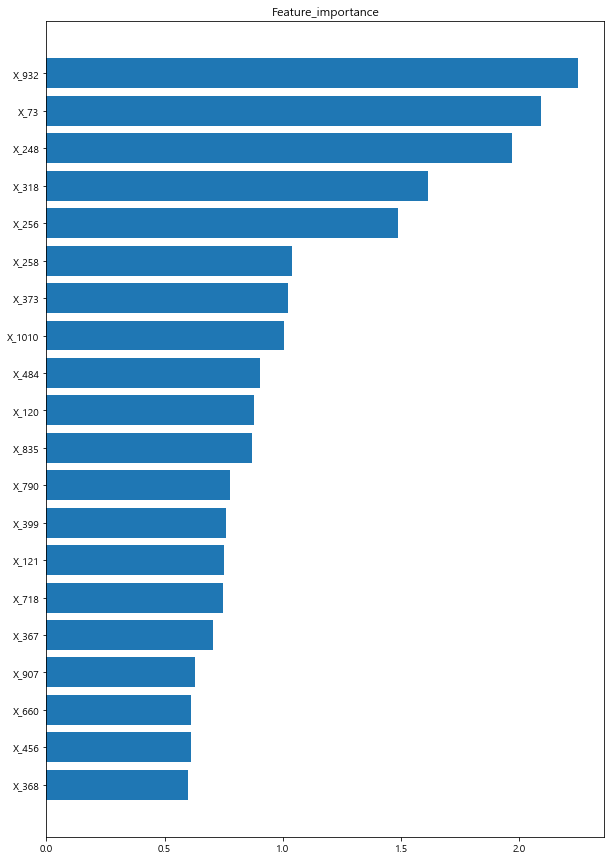

In [111]:
plt.rcParams["figure.figsize"] = (10, 15)

feat_list = np.array(feat_list)
feat_mean = np.array([np.mean(feat_list[:, i]) for i in range(len(feat_list[0]))])
feature_imp = pd.Series(feat_mean, index=train_x.columns).sort_values(ascending=False)[:20].sort_values()

plt.barh(feature_imp.index, feature_imp)
plt.title('Feature_importance')
plt.show()

In [112]:
# feature_importance > 0 인 컬럼만 선택
tmp = pd.Series(feat_mean[(feat_mean > 0)], index=train_x.columns[(feat_mean > 0)]).sort_values(ascending=False)[:]
train_x = train_x[tmp.index]
test = test[train_x.columns]
train_x

,X_932,X_73,X_248,X_318,X_256,X_258,X_373,X_1010,X_484,X_120,...,X_1988,X_1922,X_1934,X_1894,X_1278,X_1942,X_2449,X_1912,X_767,X_2452
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.24,NaN,NaN,...,0.000025,0.000000,0.000000,0.000000,415.0,0.000000,205.004412,0.000000,NaN,204.992647
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN,NaN,...,0.000009,0.453569,0.169019,0.072995,400.0,0.149518,204.994286,0.648706,NaN,204.997143
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.24,NaN,NaN,...,0.000023,0.000000,0.000000,0.000000,411.0,0.000000,204.995588,0.000000,NaN,204.995588
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN,NaN,...,0.000009,0.000000,0.000000,0.000000,400.0,0.000000,204.998551,0.000000,NaN,205.002899
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.24,NaN,NaN,...,0.000024,0.000000,0.000000,0.000000,418.0,0.000000,204.994030,0.000000,NaN,204.994030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,13.351613,10.09,NaN,NaN,NaN,NaN,NaN,NaN,186.3,34.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN
594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.08,NaN,NaN,...,NaN,0.000000,0.000000,0.000000,NaN,0.000000,205.005797,0.000000,NaN,205.002899
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.08,NaN,NaN,...,NaN,0.000000,0.000000,0.000000,NaN,0.000000,204.997101,0.000000,NaN,204.988406
596,13.406667,10.22,NaN,NaN,NaN,NaN,NaN,NaN,201.6,33.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN


In [113]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5, gpu -> task_type="GPU"
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE'])
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [08:12, 19.72s/it]

0.6032683312070956 : [0.14285714 0.68067227 0.68067227] ~ 0.7556798140131473 : [0.14285714 0.68067227 0.68067227]
mean : 0.6734166819007247


#### Permutation Importance

In [114]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

perm_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE']) # Feature_importance에서 LINE이 제거됨

    perm = PermutationImportance(clf).fit(x_val, y_val) # n_iter = 1
    perm_list.append(perm.feature_importances_)
    
eli5.show_weights(perm, feature_names = x_val.columns.tolist())

5it [27:09, 325.85s/it]


Weight,Feature
0.0168 ± 0.0000,X_1010
0.0168 ± 0.0000,X_1770
0.0151 ± 0.0067,X_257
0.0151 ± 0.0067,X_318
0.0101 ± 0.0067,X_368
0.0084 ± 0.0000,X_1116
0.0084 ± 0.0000,X_1374
0.0084 ± 0.0000,X_307
0.0084 ± 0.0000,X_1050
0.0084 ± 0.0000,X_1518


In [115]:
perm_list = np.array(perm_list)
perm_mean = np.array([np.mean(perm_list[:, i]) for i in range(len(perm_list[0]))])
tmp = pd.Series(perm_mean[(perm_mean > 0)], index=train_x.columns[(perm_mean > 0)]).sort_values(ascending=False)[:]
train_x = train_x[tmp.index]
test = test[train_x.columns]
train_x

,X_248,X_368,X_318,X_1108,X_1067,X_1050,X_1518,X_367,X_1770,X_462,...,X_491,X_1152,X_2794,X_1534,X_496,X_1354,X_456,X_428,X_1530,X_2842
0,NaN,NaN,NaN,250.722222,560290.0,560709.1304,12.244898,NaN,0.590696,NaN,...,NaN,164.9,22.296296,14.814815,NaN,484.225806,NaN,NaN,0.614057,0.000331
1,NaN,NaN,NaN,250.641509,562080.0,562493.9130,7.830040,NaN,0.346702,NaN,...,NaN,151.2,24.000000,12.761616,NaN,483.531250,NaN,NaN,5.535484,0.001150
2,NaN,NaN,NaN,250.207547,563820.0,564264.1304,10.958333,NaN,0.581820,NaN,...,NaN,167.4,23.111111,14.933333,NaN,483.903226,NaN,NaN,5.743548,0.000332
3,NaN,NaN,NaN,250.603774,566180.0,566598.2609,11.803571,NaN,0.386272,NaN,...,NaN,166.7,24.037037,17.037037,NaN,483.062500,NaN,NaN,11.012903,0.001210
4,NaN,NaN,NaN,253.018518,577470.0,577883.9130,12.020408,NaN,0.548954,NaN,...,NaN,167.6,23.037037,16.740741,NaN,483.387097,NaN,NaN,5.322222,0.000334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2261.0,...,393.581818,NaN,NaN,NaN,0.687273,NaN,8.122449,-61.454545,NaN,NaN
594,NaN,NaN,NaN,252.622641,968880.0,969331.3043,12.865979,NaN,0.558585,NaN,...,NaN,179.5,23.464286,13.925926,NaN,483.354839,NaN,NaN,10.974194,0.000124
595,NaN,NaN,NaN,252.566038,973580.0,974029.7872,13.171271,NaN,0.641909,NaN,...,NaN,182.5,23.464286,14.777778,NaN,481.935484,NaN,NaN,10.900000,0.000195
596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2268.0,...,393.890909,NaN,NaN,NaN,0.692727,NaN,8.560000,-52.363636,NaN,NaN


In [116]:
### 변수를 추가? pca같은걸로
### 아니면 줄어든 변수로 lda?

In [117]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5, gpu -> task_type="GPU"
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [04:36, 11.04s/it]

0.5689631117807914 : [0.14285714 0.68067227 0.68067227] ~ 0.7963679853964057 : [0.14285714 0.68067227 0.68067227]
mean : 0.6896043482733389


In [118]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

perm_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100) # Feature_importance에서 LINE이 제거됨

    perm = PermutationImportance(clf).fit(x_val, y_val) # n_iter = 1
    perm_list.append(perm.feature_importances_)
    
eli5.show_weights(perm, feature_names = x_val.columns.tolist())

5it [02:18, 27.72s/it]


Weight,Feature
0.0420 ± 0.0106,X_1010
0.0218 ± 0.0082,X_1625
0.0185 ± 0.0067,X_1526
0.0151 ± 0.0067,X_1047
0.0151 ± 0.0067,X_1040
0.0151 ± 0.0067,X_380
0.0151 ± 0.0165,X_247
0.0134 ± 0.0082,X_995
0.0134 ± 0.0082,X_1053
0.0134 ± 0.0082,X_1617


In [123]:
perm_list = np.array(perm_list)
perm_mean = np.array([np.mean(perm_list[:, i]) for i in range(len(perm_list[0]))])
tmp = pd.Series(perm_mean[(perm_mean > 0)], index=train_x.columns[(perm_mean > 0)]).sort_values(ascending=False)[:50]
train_x = train_x[tmp.index]
test = test[train_x.columns]
train_x.head()

,X_1010,X_73,X_793,X_999,X_1625,X_380,X_1040,X_247,X_995,X_248,...,X_491,X_1671,X_513,X_1183,X_2081,X_1083,X_893,X_854,X_121,X_497
0,8.24,NaN,NaN,412.0,65527.70968,0.0,613930.0,NaN,102.0,NaN,...,NaN,29.6,NaN,840.0,0.000368,28.7,NaN,NaN,NaN,NaN
1,8.00,NaN,NaN,415.0,65527.65625,0.0,615880.0,NaN,102.0,NaN,...,NaN,29.6,NaN,830.0,0.002083,28.0,NaN,NaN,NaN,NaN
2,8.24,NaN,NaN,418.0,65527.70968,0.0,617840.0,NaN,103.0,NaN,...,NaN,29.6,NaN,880.0,0.000395,28.8,NaN,NaN,NaN,NaN
3,8.00,NaN,NaN,422.0,65527.75000,0.0,620370.0,NaN,104.0,NaN,...,NaN,29.6,NaN,840.0,0.001340,28.1,NaN,NaN,NaN,NaN
4,8.24,NaN,NaN,442.0,65527.70968,0.0,632720.0,NaN,109.0,NaN,...,NaN,29.6,NaN,830.0,0.000379,26.8,NaN,NaN,NaN,NaN


In [127]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5, gpu -> task_type="GPU"
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [04:17, 10.31s/it]

0.5831541218637993 : [0.15  0.675 0.675] ~ 0.817954335231975 : [0.15  0.675 0.675]
mean : 0.7004616285354212


In [125]:
for c in train_x.columns:
    print(f'"{c}", ')

"X_1010", 
"X_73", 
"X_793", 
"X_999", 
"X_1625", 
"X_380", 
"X_1040", 
"X_247", 
"X_995", 
"X_248", 
"X_530", 
"X_1617", 
"X_373", 
"X_367", 
"X_1111", 
"X_368", 
"X_492", 
"X_1099", 
"X_1053", 
"X_1786", 
"X_1343", 
"X_1526", 
"X_1115", 
"X_1002", 
"X_1143", 
"X_141", 
"X_339", 
"X_309", 
"X_967", 
"X_1616", 
"X_531", 
"X_20", 
"X_452", 
"X_1047", 
"X_1107", 
"X_993", 
"X_1945", 
"X_1668", 
"X_1033", 
"X_939", 
"X_491", 
"X_1671", 
"X_513", 
"X_1183", 
"X_2081", 
"X_1083", 
"X_893", 
"X_854", 
"X_121", 
"X_497", 


### 결측치 대체

#### Mice

In [128]:
mice = IterativeImputer()
train_x_mice = mice.fit_transform(train_x)
train_x_mice = pd.DataFrame(train_x_mice, columns=train_x.columns)
test_mice = pd.DataFrame(mice.transform(test), columns=test.columns)

# 메모리 초과를 막기위해 제거
import gc
del mice
gc.collect()

train_x_mice

,X_1010,X_73,X_793,X_999,X_1625,X_380,X_1040,X_247,X_995,X_248,...,X_491,X_1671,X_513,X_1183,X_2081,X_1083,X_893,X_854,X_121,X_497
0,8.240000e+00,9.990833,406.510555,4.120000e+02,6.552771e+04,0.000000e+00,6.139300e+05,-8.169282e+08,1.020000e+02,2.461577e+10,...,394.056391,2.960000e+01,36.796071,8.400000e+02,3.680000e-04,2.870000e+01,606.947166,0.654397,34.373908,41.300982
1,8.000000e+00,9.990833,406.510555,4.150000e+02,6.552766e+04,0.000000e+00,6.158800e+05,-1.131102e+10,1.020000e+02,3.408248e+11,...,394.056391,2.960000e+01,36.796071,8.300000e+02,2.083077e-03,2.800000e+01,606.947166,0.654397,34.373908,41.300982
2,8.240000e+00,9.990833,406.510555,4.180000e+02,6.552771e+04,0.000000e+00,6.178400e+05,-2.874038e+10,1.030000e+02,8.660079e+11,...,394.056391,2.960000e+01,36.796071,8.800000e+02,3.951670e-04,2.880000e+01,606.947166,0.654397,34.373908,41.300982
3,8.000000e+00,9.990833,406.510555,4.220000e+02,6.552775e+04,0.000000e+00,6.203700e+05,1.018276e+10,1.040000e+02,-3.068278e+11,...,394.056391,2.960000e+01,36.796071,8.400000e+02,1.340000e-03,2.810000e+01,606.947166,0.654397,34.373908,41.300982
4,8.240000e+00,9.990833,406.510555,4.420000e+02,6.552771e+04,0.000000e+00,6.327200e+05,1.054352e+10,1.090000e+02,-3.176982e+11,...,394.056391,2.960000e+01,36.796071,8.300000e+02,3.790000e-04,2.680000e+01,606.947166,0.654397,34.373908,41.300982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,-4.645908e+58,10.090000,407.000000,1.841167e+48,1.371868e+49,2.810767e+46,2.321909e+61,6.485653e+65,1.916601e+50,-1.954264e+67,...,393.581818,-7.435246e+47,39.000000,-1.882819e+57,6.124121e+52,-2.210580e+48,806.000000,0.630000,34.100000,42.072727
594,8.080000e+00,9.990833,406.510555,1.385000e+03,6.552716e+04,3.000000e+00,1.043490e+06,-3.759660e+10,2.960000e+02,1.132864e+12,...,394.056391,2.880000e+01,36.796071,8.900000e+02,-6.226203e-03,2.880000e+01,606.947166,0.654397,34.373908,41.300982
595,8.080000e+00,9.990833,406.510555,1.394000e+03,6.552774e+04,3.000000e+00,1.048600e+06,-3.198940e+10,2.980000e+02,9.639076e+11,...,394.056391,2.900000e+01,36.796071,8.800000e+02,-5.060898e-03,2.910000e+01,606.947166,0.654397,34.373908,41.300982
596,-5.657297e+58,10.220000,407.000000,2.329026e+48,1.649804e+49,3.880638e+46,2.827376e+61,7.897544e+65,3.396065e+50,-2.379697e+67,...,393.890909,-1.315959e+48,39.000000,-2.292698e+57,7.457309e+52,-3.911361e+48,809.000000,1.040000,33.700000,42.781818


In [129]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x_mice, train_y))):
    x_trn, x_val, y_trn, y_val = train_x_mice.loc[train_index], train_x_mice.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [04:18, 10.34s/it]

0.6199760366427033 : [0.15       0.68333333 0.68333333] ~ 0.747936507936508 : [0.15       0.68333333 0.68333333]
mean : 0.6759603603172097


#### fillna(0)

In [130]:
train_x_fill0 = train_x.fillna(0)
test_fill0 = test.fillna(0)

In [131]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x_fill0, train_y))):
    x_trn, x_val, y_trn, y_val = train_x_fill0.loc[train_index], train_x_fill0.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [04:21, 10.44s/it]

0.5740930018416206 : [0.14285714 0.68067227 0.68067227] ~ 0.8021557160876046 : [0.14285714 0.68067227 0.68067227]
mean : 0.7008717570774414


In [132]:
train_x = train_x_fill0
test = test_fill0
# train_x = train_x_mice
# test = test_mice

### Data Scaling (random, SMOTE ENN, SMOTE Tomek, ADASYN, Borderline SMOTE)

In [133]:
def Randomoversampler(train_x_df, train_y_df):
    x_ros, y_ros = RandomOverSampler().fit_resample(train_x_df, train_y_df)
    return x_ros, y_ros

In [134]:
def SMOTE_Tomek(train_x_df, train_y_df):
    x_smoteenn, y_smoteenn = SMOTETomek().fit_resample(train_x_df, train_y_df)
    return x_smoteenn, y_smoteenn

In [135]:
def SMOTE_ENN(train_x_df, train_y_df):
    x_smoteenn, y_smoteenn = SMOTEENN().fit_resample(train_x_df, train_y_df)
    return x_smoteenn, y_smoteenn

In [136]:
def ADASYN_(train_x_df, train_y_df):
    x_adasyn, y_adasyn = ADASYN(sampling_strategy='minority').fit_resample(train_x_df, train_y_df)
    return x_adasyn, y_adasyn

In [137]:
def Borderline_SMOTE(train_x_df, train_y_df):
    x_b_smote, y_b_smote = BorderlineSMOTE().fit_resample(train_x_df, train_y_df)
    return x_b_smote, y_b_smote

#### RandomOverSampling

In [142]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = Randomoversampler(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [04:15, 10.24s/it]

0.6038095238095239 : [0.14285714 0.68067227 0.68067227] ~ 0.8035305041883989 : [0.14285714 0.68067227 0.68067227]
mean : 0.6973886900707084


#### SMOTE_ENN

In [138]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = SMOTE_ENN(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [04:14, 10.17s/it]

0.46813241106719367 : [0.15  0.675 0.675] ~ 0.6522410091250671 : [0.15  0.675 0.675]
mean : 0.555705004954021


#### SMOTE_Tomek

In [139]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = SMOTE_Tomek(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [04:15, 10.21s/it]

0.5937897959736635 : [0.15       0.68333333 0.68333333] ~ 0.7387617282354123 : [0.15       0.68333333 0.68333333]
mean : 0.674892484244255


#### ADASYN

In [140]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = ADASYN_(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [04:11, 10.05s/it]

0.6121832358674465 : [0.14285714 0.68067227 0.68067227] ~ 0.7582408052392022 : [0.14285714 0.68067227 0.68067227]
mean : 0.6932911689304437


#### BorderlineSMOTE

In [141]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = Borderline_SMOTE(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} : {class_rate[f1_list.index(min(f1_list))]} ~ {max(f1_list)} : {class_rate[f1_list.index(min(f1_list))]}')
print('mean :', np.mean(f1_list))

25it [04:09,  9.97s/it]

0.5788834154351395 : [0.15       0.68333333 0.68333333] ~ 0.7936224995048523 : [0.15       0.68333333 0.68333333]
mean : 0.692755011321022


In [81]:
# train_x.to_csv('train_x_pp.csv', index=False)
# train_y.to_csv('train_y_pp.csv', index=False)
# test.to_csv('test_pp.csv', index=False)

In [72]:
def cb_objective(trial):

    params = {
            'iterations':trial.suggest_int("iterations", 500, 3000),
            'objective':trial.suggest_categorical('objective',['MultiClass']),
            'bootstrap_type':trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
            'od_wait':trial.suggest_int('od_wait', 500, 1000),
            'learning_rate' : trial.suggest_uniform('learning_rate',0.01,1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
            'random_strength': trial.suggest_uniform('random_strength',20,50),
            'depth': trial.suggest_int('depth',1,15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,20),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'verbose': False,
            "eval_metric":'TotalF1',
            #"cat_features" : ['PRODUCT_CODE', 'LINE'],
            "one_hot_max_size": trial.suggest_int("one_hot_max_size",1,5),
            #'task_type' : 'GPU',
            'thread_count': 5,
        }

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    clf = catboost.CatBoostClassifier(**params)

    f1_list = []
    for fold, (train_index, val_index) in enumerate(rskfold.split(train_x, train_y)):
        x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
        x_trn, y_trn = ADASYN_(x_trn, y_trn)
        
        clf.fit(x_trn, y_trn, early_stopping_rounds=100)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
    return np.mean(f1_list)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(cb_objective, n_trials=30, show_progress_bar=True)

[I 2023-02-15 04:38:46,472] A new study created in memory with name: no-name-671aaf02-fe0f-4c2f-a0a0-88731561e2a3


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-02-15 05:13:17,172] Trial 0 finished with value: 0.6650594996723143 and parameters: {'iterations': 2956, 'objective': 'MultiClass', 'bootstrap_type': 'Bayesian', 'od_wait': 608, 'learning_rate': 0.2720685531929709, 'reg_lambda': 2.099152185966509, 'random_strength': 31.47925599581413, 'depth': 10, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 3, 'one_hot_max_size': 1, 'bagging_temperature': 0.9948990492561449}. Best is trial 0 with value: 0.6650594996723143.
[I 2023-02-15 05:20:35,449] Trial 1 finished with value: 0.6856736597992343 and parameters: {'iterations': 1253, 'objective': 'MultiClass', 'bootstrap_type': 'Bernoulli', 'od_wait': 698, 'learning_rate': 0.11334709986236198, 'reg_lambda': 35.73812988558261, 'random_strength': 29.761704529297656, 'depth': 9, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 2, 'one_hot_max_size': 1, 'subsample': 0.3747885173762048}. Best is trial 1 with value: 0.6856736597992343.
[I 2023-02-15 05:21:06,566] Trial 2 finished with va

In [86]:
print(study.best_trial)
print(study.best_params)

{'iterations': 1337,
 'objective': 'MultiClass',
 'bootstrap_type': 'Bayesian',
 'od_wait': 552,
 'learning_rate': 0.6128454724915484,
 'reg_lambda': 77.08090755141544,
 'random_strength': 43.1413895840195,
 'depth': 3,
 'min_data_in_leaf': 20,
 'leaf_estimation_iterations': 2,
 'one_hot_max_size': 1,
 'bagging_temperature': 0.06040383536784377}

In [88]:
clf = catboost.CatBoostClassifier(**study.best_params, verbose=0).fit(train_x, train_y)
pred = clf.predict(test)
subm['Y_Class'] = pred

In [144]:
subm.Y_Class.value_counts()

1    256
0     30
2     24
Name: Y_Class, dtype: int64

In [145]:
subm.to_csv('./submission_33.csv', index=False)

In [ ]:
# y_Quality

In [ ]:
# 0 / 1, 2 랑 0, 1 / 2로 나누어서? 모델을 두 가지 만들면 될 듯